In [1]:
import numpy as np
import pandas as pd

# Učitajte dataset
dataset = pd.read_csv('./letters.csv').astype(np.float32)

In [2]:
dataset.shape

(372450, 785)

In [3]:
dataset.columns = ['label'] + [f'pixel_{i}' for i in range(784)]
Y = dataset.label
X = dataset.drop('label', axis=1)
letters =[chr(i) for i in range(65, 91)]
letters

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

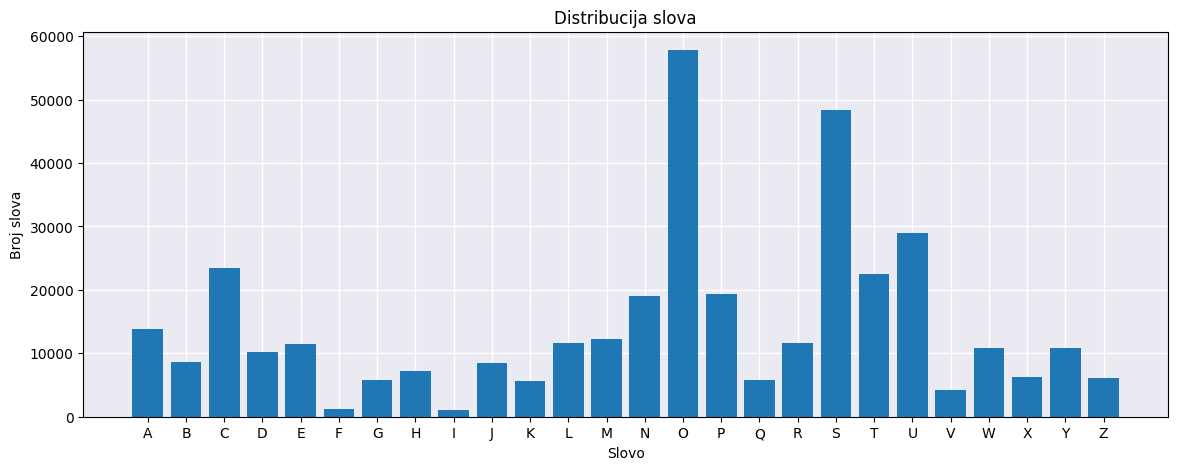

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.bar(letters, Y.value_counts().sort_index(), zorder=2)
plt.title('Distribucija slova')
plt.xlabel('Slovo')
plt.ylabel('Broj slova')
plt.grid(color='white', linestyle='-', linewidth=1, zorder=1)
plt.gca().set_facecolor('#eaeaf2')
plt.show()

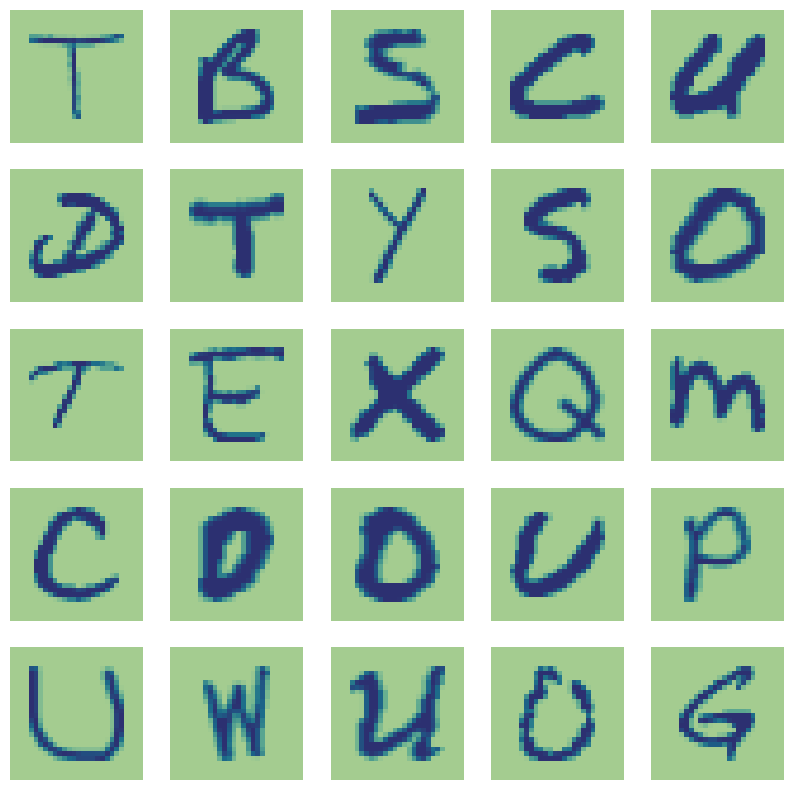

In [6]:
random_indices = np.random.choice(range(len(X)), size=25, replace=False)
_, axes = plt.subplots(5, 5, figsize=(10, 10))
acc = 7
for i,ax in enumerate(axes.ravel()):
    ax.imshow(X.iloc[random_indices[i]].values.reshape(28, 28), cmap='crest')
    ax.axis('off')
plt.show()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim

# Učitavanje podataka
file_path = './letters.csv'
data = pd.read_csv(file_path)

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# Transformacija oznaka u numeričke vrijednosti
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Podjela podataka na trening i test sklopove
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class LetterDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = LetterDataset(X_train, y_train)
test_dataset = LetterDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_classes = len(set(y))
model = SimpleNN(input_size, hidden_size, num_classes)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.2006
Epoch [2/20], Loss: 1.0802
Epoch [3/20], Loss: 0.2266
Epoch [4/20], Loss: 0.5806
Epoch [5/20], Loss: 0.9486
Epoch [6/20], Loss: 0.0525
Epoch [7/20], Loss: 0.0192
Epoch [8/20], Loss: 0.2270
Epoch [9/20], Loss: 0.0620
Epoch [10/20], Loss: 0.0424
Epoch [11/20], Loss: 0.6213
Epoch [12/20], Loss: 0.1660
Epoch [13/20], Loss: 0.0118
Epoch [14/20], Loss: 0.1319
Epoch [15/20], Loss: 0.6095
Epoch [16/20], Loss: 0.0796
Epoch [17/20], Loss: 0.0926
Epoch [18/20], Loss: 1.3458
Epoch [19/20], Loss: 0.0365
Epoch [20/20], Loss: 0.0382


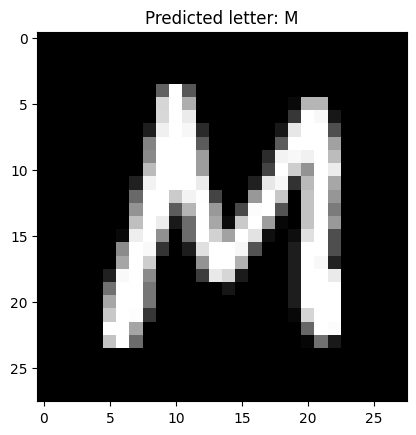

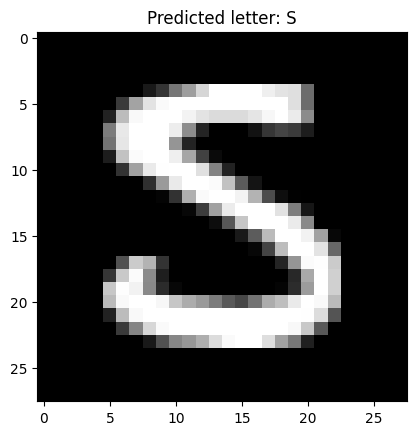

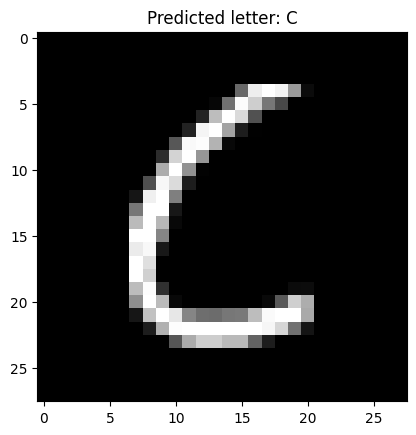

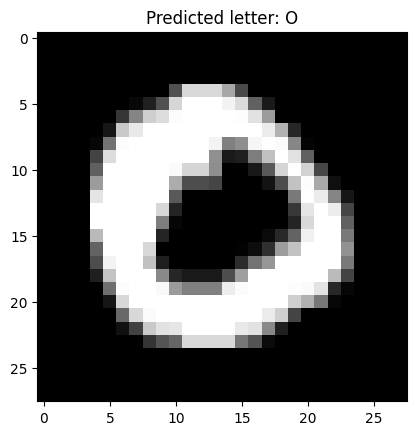

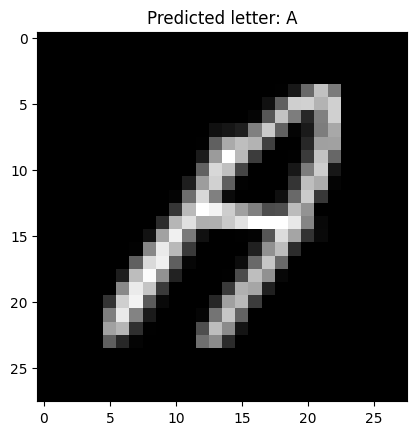

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Funkcija za predikciju slova
def predict_letter(image, model):
    model.eval()
    with torch.no_grad():
        image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0) 
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        return chr(predicted.item() + 65)  # ASCII vrijednost za 'A' počinje od 65

# Prikazivanje slika i njihovih predviđenih vrijednosti
for i in range(5):
    image = X_test[i].reshape(28, 28)
    predicted_letter = predict_letter(X_test[i], model)
    
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted letter: {predicted_letter}')
    plt.show()


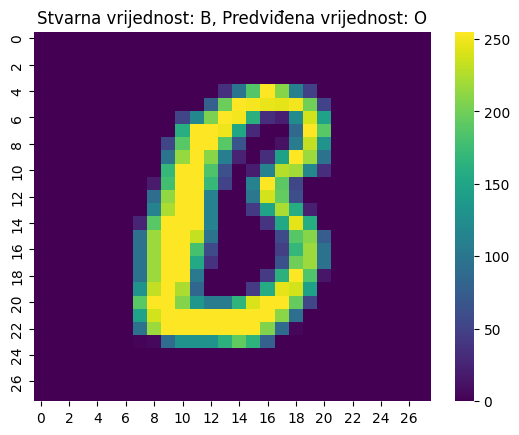

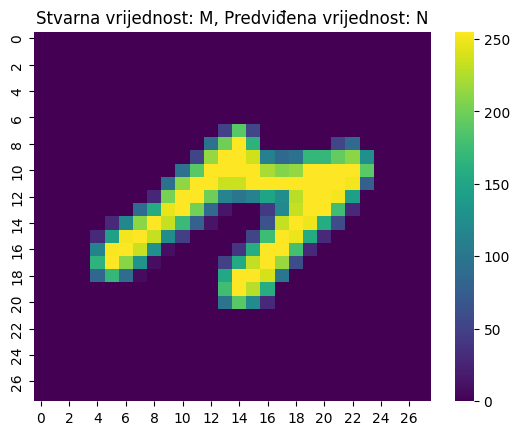

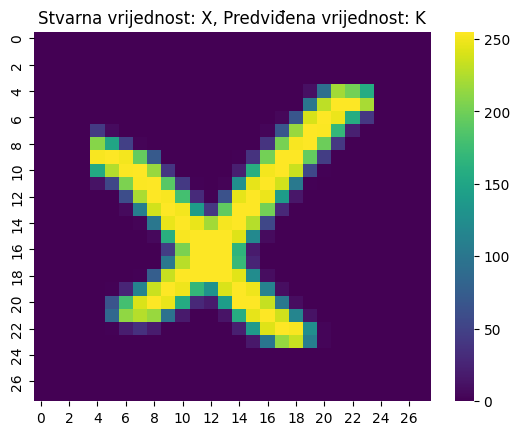

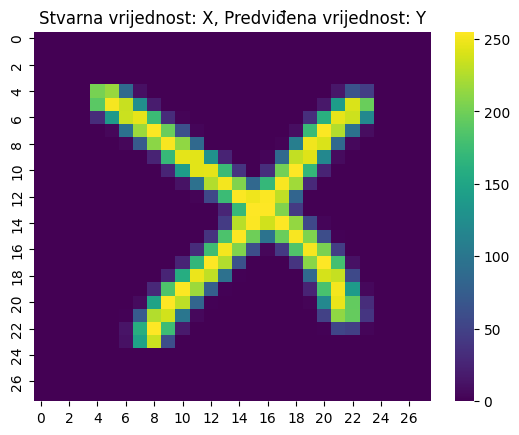

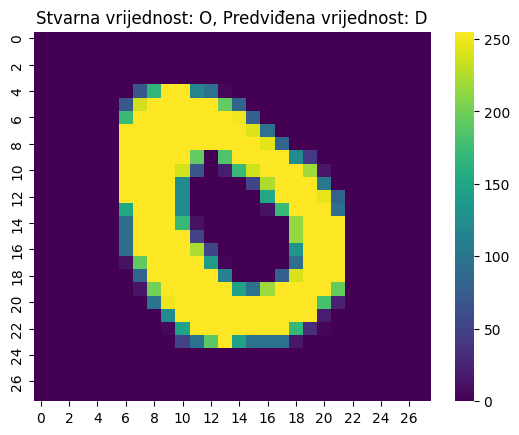

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Funkcija za predikciju slova
def predict(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for features, labels in data_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_predictions), np.array(all_labels)

# Dobijanje svih predikcija za test set
predictions, true_labels = predict(model, test_loader)

# Identifikacija krivo pogodjenih slova
wrong_predictions = np.where(predictions != true_labels)[0]

# Prikazivanje krivo pogođenih slova
for i in range(min(5, len(wrong_predictions))):
    idx = wrong_predictions[i]
    image = X_test[idx].reshape(28, 28)
    true_letter = chr(true_labels[idx] + 65)
    predicted_letter = chr(predictions[idx] + 65)
    
    sns.heatmap(image, cmap='viridis')
    plt.title(f'Stvarna vrijednost: {true_letter}, Predviđena vrijednost: {predicted_letter}')
    plt.show()
